In [2]:
from functools import partial
from sqlite3 import connect

import astroplan as ap
from astropy.coordinates import EarthLocation
from astropy.table import Table
from astropy.time import Time
import astropy.units as u
from icecream import ic, install
import numpy as np
import pandas as pd

import astropaul.targetlistcreator as tlc
import astropaul.lbt as lbt
import astropaul.html as html
import astropaul.phase as ph
import astropaul.priority as pr

install() # icecream will now work in imported packages

%load_ext autoreload
%autoreload 2

# from itables import init_notebook_mode

# init_notebook_mode(
#     all_interactive=True,
#     connected=True,
# )

In [10]:
conn = connect("../../django/TargetDB/db.sqlite3")
html_dir = "html"

session = tlc.ObservingSession(ap.Observer.at_site("LBT"))
session.add_day_range("2024-12-21", "2024-12-28")

phase_event_defs = [
    ph.PhaseEventDef("Mid Eclipse", partial(ph.calc_time_of_phase, phase=0.0)),
    ph.PhaseEventDef("Egress", partial(ph.calc_time_of_gress, ingress=False)),
    ph.PhaseEventDef("Ingress", partial(ph.calc_time_of_gress, ingress=True)),
]

pepsi_args = {
    "fiber": "300",
    "cd_blue": 3,
    "cd_red": 6,
    "snr": 100,
    "binocular": True,
    # "priority": "(see grid)",
}

name = "LBT Observing List 2024-12-21"
creator = tlc.TargetListCreator(name=name, connection=conn)
creator.steps = [
    tlc.add_targets,
    partial(tlc.filter_targets, criteria=lambda df: (df["Target Type"] == "QuadEB")),
    tlc.add_tess,
    tlc.add_coords,
    partial(tlc.hide_cols, prefix="TESS "),
    tlc.add_speckle,
    tlc.add_pepsi,
    tlc.add_lists,
    tlc.add_ephemerides,
    partial(tlc.filter_targets, criteria=lambda df: (df["Num PEPSI"] > 0)),
    partial(tlc.filter_targets, criteria=lambda df: (df["List LBT 2024B"])),
    partial(tlc.concat_dataframe, other_df=pd.read_csv("Calibration Targets.csv")),
    partial(tlc.add_observability, observing_session=session, calc_max_altitude=True, calc_moon_distance=True),
    partial(tlc.filter_targets, criteria=lambda df: (df["Observable Every Night"])),
    partial(tlc.filter_targets, criteria=lambda df: (df["Observable Max Alt"] > 40)),
    partial(tlc.filter_targets, inverse=True, criteria=lambda df: np.isnan(df["Teff"])),
    partial(lbt.add_pepsi_params, **pepsi_args),
    partial(tlc.filter_targets, criteria=lambda df: df["PEPSI exp_time"] < 600),
    # partial(lbt.assign_rv_standards, science_types=["QuadEB", "SextEB"], rv_standard_type="RV Standard"),
    partial(tlc.add_phase_events, observing_session=session, phase_event_defs=phase_event_defs),
]
tl = creator.calculate(verbose=False)
tl.target_list["PEPSI notes"] = [type.replace("QuadEB", "Science Target") for type in tl.target_list["Target Type"]]
# readme = lbt.write_lbt_readme_file("UVa_Multistar", tl.target_list)

print(tl.summarize())
print(f"{np.sum(tl.target_list["PEPSI exp_time"])/60:.1f} minutes")
tl.target_list

LBT Observing List 2024-12-21
28 targets:
      16 QuadEB
       9 RV Standard
       3 Telluric Standard
Column Count (primary, secondary):
    Target: (1, 2)
    Coordinates: (6, 3)
    Count: (2, 0)
    List : (0, 10)
    Observable: (5, 28)
    PEPSI : (3, 6)
Associated tables:
     148 rows,  6 columns: Speckle
     103 rows,  9 columns: PEPSI
     656 rows,  6 columns: Ephem
       7 rows,  2 columns: Lunar Phases
    7674 rows,  8 columns: Phase Events

65.2 minutes


,Target Name,Target Source,Target Type,ra,dec,pmra,pmdec,parallax,Vmag,Teff,...,Observable Min Moon Dist,PEPSI fiber,PEPSI cd_blue,PEPSI cd_blue_num_exp,PEPSI cd_red,PEPSI cd_red_num_exp,PEPSI snr,PEPSI exp_time,PEPSI priority,PEPSI notes
4215,TIC 367448265,Kostov 2022 arXiv:2202.05790,QuadEB,78.382438,35.653053,-5.85675,-3.432870,3.264150,7.900,9212.00,...,78.050924,300,3,1,6,1,100,60,,Science Target
4219,TIC 25818450,Kostov 2022 arXiv:2202.05790,QuadEB,352.743444,53.069150,3.57360,-1.172130,1.065210,11.782,7172.00,...,116.316118,300,3,1,6,1,100,341,,Science Target
4223,TIC 414026507,Kostov 2022 arXiv:2202.05790,QuadEB,336.837717,56.740362,-3.66449,-2.956470,0.242427,10.899,9187.00,...,113.417609,300,3,1,6,1,100,137,,Science Target
4225,TIC 470710327,Kostov 2022 arXiv:2202.05790,QuadEB,357.329052,61.962787,0.60000,-2.500000,NaN,9.650,8986.00,...,107.093038,300,3,1,6,1,100,60,,Science Target
4229,TIC 89278612,Kostov 2022 arXiv:2202.05790,QuadEB,301.219498,32.643051,-0.48521,-1.506920,0.663315,11.235,8740.00,...,90.290277,300,3,1,6,1,100,187,,Science Target
4231,TIC 278352276,Kostov 2022 arXiv:2202.05790,QuadEB,307.503640,48.607056,1.85387,6.576640,1.362650,10.387,7156.00,...,100.960539,300,3,1,6,1,100,94,,Science Target
4232,TIC 123098844,Kostov 2022 arXiv:2202.05790,QuadEB,279.572843,44.698600,3.48250,-9.104270,1.309250,11.136,6761.00,...,82.562704,300,3,1,6,1,100,189,,Science Target
4236,TIC 322727163,Kostov 2022 arXiv:2202.05790,QuadEB,309.716625,50.466821,2.80000,-7.500000,NaN,10.997,7876.56,...,102.930246,300,3,1,6,1,100,154,,Science Target
4240,TIC 427092089,Kostov 2022 arXiv:2202.05790,QuadEB,321.112009,64.380683,-2.81497,-2.828370,0.728287,12.367,8760.00,...,104.397957,300,3,1,6,1,100,530,,Science Target
4277,TIC 454140642,Kostov 2022 arXiv:2202.05790,QuadEB,64.773473,0.900042,2.82736,-10.846600,2.712150,10.409,6592.00,...,95.606667,300,3,1,6,1,100,97,,Science Target


In [11]:
illumination_categories = [
    ((0.0, 0.4), "Dark"),
    ((0.4, 0.7), "Gray"),
    ((0.7, 1.0), "Bright"),
]

distance_categories = {
    "Dark": [
        ((0, 180), 1),
    ],
    "Gray": [
        ((0, 5), 0.1),
        ((5, 15), 0.75),
        ((15, 180), 1),
    ],
    "Bright": [
        ((0, 15), 0.25),
        ((15, 30), 0.75),
        ((30, 180), 1),
    ],
}

altitude_categories = [
    ((-90, 35), 0),
    ((35, 45), 0.85),
    ((45, 60), 0.95),
    ((60, 90), 1),
]

phase_defs = [
    ph.PhaseEventDef("T", partial(ph.calc_time_of_phase, phase=0.0)),
    ph.PhaseEventDef("B", partial(ph.calc_time_of_phase, phase=0.05)),
    ph.PhaseEventDef("R", partial(ph.calc_time_of_phase, phase=0.18)),
    ph.PhaseEventDef("B", partial(ph.calc_time_of_phase, phase=0.32)),
    ph.PhaseEventDef("T", partial(ph.calc_time_of_phase, phase=0.45)),
    ph.PhaseEventDef("B", partial(ph.calc_time_of_phase, phase=0.55)),
    ph.PhaseEventDef("R", partial(ph.calc_time_of_phase, phase=0.68)),
    ph.PhaseEventDef("B", partial(ph.calc_time_of_phase, phase=0.82)),
    ph.PhaseEventDef("T", partial(ph.calc_time_of_phase, phase=0.95)),
]

phase_scores = {
    "B|B": 0.5,
    "B|R": 0.8,
    "B|T": 0.4,
    "R|R": 0.9,
    "R|T": 1,
    "T|T": 0.1,
}

science_tl = tl.copy()
science_tl.target_list = science_tl.target_list[science_tl.target_list["Target Type"] == "QuadEB"]
pl = pr.PriorityList(science_tl, session, interval=60 * u.min)
pr.calculate_moon_priority(pl, illumination_categories=illumination_categories, dist_categories=distance_categories)
pr.calculate_altitude_priority(pl, altitude_categories=altitude_categories)
pr.calculate_list_priority(pl, "HQND", false_value=0.75)
pr.calculate_phase_priority(pl, phase_defs=phase_defs, phase_categories=phase_scores)
pr.calculate_overall_priority(pl)
pr.aggregate_target_priorities(pl, skip_column_threshold=0.1)
pl.categorize_priorities(
    bins=[0.00, 0.20, 0.40, 0.6, 1.00], labels=["", "*", "* *", "* * *"]
)

 '2024-12-21T03:00:00.000000000' '2024-12-21T04:00:00.000000000'
 '2024-12-21T05:00:00.000000000' '2024-12-21T06:00:00.000000000'
 '2024-12-21T07:00:00.000000000' '2024-12-21T08:00:00.000000000'
 '2024-12-21T09:00:00.000000000' '2024-12-21T10:00:00.000000000'
 '2024-12-21T11:00:00.000000000' '2024-12-21T12:00:00.000000000'
 '2024-12-21T13:00:00.000000000'], obsgeoloc=[( 5361940.70731326, -477038.21320319, 3414752.84153776),
 ( 5302353.27820425,  928639.96999047, 3414848.18017465),
 ( 4880019.00181227, 2270696.08027767, 3415825.58503097),
 ( 4123876.16737285, 3457172.61719983, 3417618.09239232),
 ( 3085735.58105186, 4406772.37145876, 3420102.88797978),
 ( 1836730.49655731, 5054428.89863176, 3423109.72159553),
 (  462442.57427659, 5355764.86308382, 3426432.57211383),
 ( -942962.16244353, 5290132.76696231, 3429843.76357012),
 (-2283185.57039883, 4862029.71393765, 3433109.56514634),
 (-3466395.72219118, 4100789.26826979, 3436006.20616543),
 (-4411519.21739107, 3058571.52297694, 3438335.208

In [13]:

readme = lbt.write_lbt_readme_file("UVa_Multistar", tl.target_list, session)
with open("UVa_Multistar.README", "w") as f:
    f.write(readme)

other_files = {
    "LBT Readme": lbt.write_lbt_readme_file("UVa_Multistar", tl.target_list, session),
    "LBT CSV": open("UVa_Multistar.csv", "r").readlines(),
}

html.render_observing_pages(tl, pl, other_files, "html")
pl.categorical_priorities[0]

,TIC 89278612,TIC 278352276,TIC 427092089,TIC 414026507,TIC 25818450,TIC 470710327,TIC 283940788,TIC 307119043,TIC 52856877,TIC 389836747,TIC 328181241,TIC 454140642,TIC 367448265,TIC 336882813
2024-12-21 01:00:00,* *,* * *,*,* *,*,* * *,*,*,* * *,* * *,* *,,,
2024-12-21 02:00:00,,* * *,* *,* *,*,* *,*,*,* * *,* * *,* *,,,
2024-12-21 03:00:00,,,* * *,* *,*,* *,* *,*,* * *,* * *,* *,* * *,* * *,
2024-12-21 04:00:00,,,,* *,*,* *,* *,*,* * *,* *,* * *,* * *,*,* *
2024-12-21 05:00:00,,,,,*,* * *,* *,,* * *,* *,* *,* * *,*,* *
2024-12-21 06:00:00,,,,,,* * *,*,,* * *,*,* *,* * *,*,* * *
2024-12-21 07:00:00,,,,,,,,*,* * *,*,* *,* * *,*,* * *
2024-12-21 08:00:00,,,,,,,,,,,,* * *,* * *,* * *
2024-12-21 09:00:00,,,,,,,,,,,,,*,* * *
2024-12-21 10:00:00,,,,,,,,,,,,,* * *,* * *


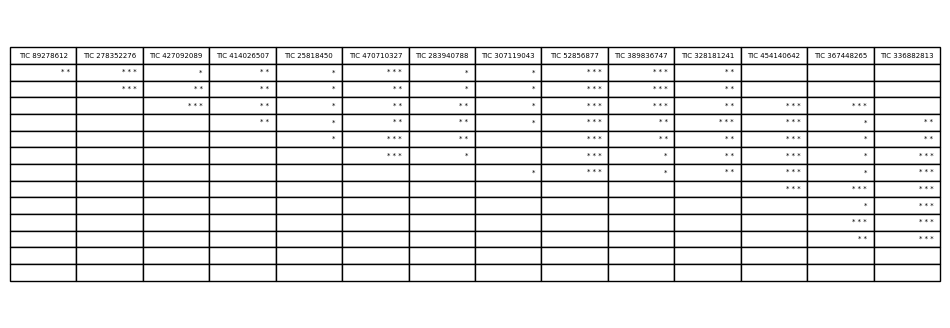

In [12]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

df = pl.categorical_priorities[0].copy()

fig, ax = plt.subplots(figsize=(12, 4))
ax.axis("tight")
ax.axis("off")
the_table = ax.table(cellText=df.values, colLabels=df.columns, loc="center")

pp = PdfPages("foo.pdf")
pp.savefig(fig, bbox_inches="tight")
pp.close()

In [4]:
from playwright.sync_api import sync_playwright


def html_to_pdf(input_html_path, output_pdf_path):
    with sync_playwright() as p:
        # Launch a browser
        browser = p.chromium.launch()
        page = browser.new_page()

        # Load the local HTML file
        page.goto(input_html_path)

        # Generate the PDF
        page.pdf(path=output_pdf_path, format="A4")
        print(f"PDF saved to {output_pdf_path}")

        # Close the browser
        browser.close()


# Call the function
html_to_pdf("test.html", "asd.pdf")

Error: It looks like you are using Playwright Sync API inside the asyncio loop.
Please use the Async API instead.

In [9]:
with open("html/Categorical Priorities 2024-12-21.html", "r") as f:
    content = f.read()

from playwright.sync_api import sync_playwright

with sync_playwright() as p:
    browser = p.chromium.launch()
    page = browser.new_page()
    # page.set_content(content)
    page.goto("file://test.html")
    page.pdf("foo.pdf")
    browser.close()

Error: It looks like you are using Playwright Sync API inside the asyncio loop.
Please use the Async API instead.